# Estimate static yaw misalignments with the help of AutoML

Using both wind speed and power estimates from AutoML.

## Improvements

1. Include timestamp in the dataset?
1. Would be great if it can continue learning from AutoMLs current states!
1. Add license to github repo!

## Load the data!

In [1]:
import requests
from pathlib import Path
from tqdm import tqdm

import re
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import zipfile

from autogluon.tabular import TabularPredictor

import os

import pickle

d:\GitHub\wind-automl\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
target_turbine = "Kelmarsh_6"
autoML_duration_mins = 10

In [3]:
BYTES_MB = 1024 * 1024

In [4]:
def download_file(url: str, outfile: str | Path) -> None:
    """
    Download a file from the web, based on its url, and save to the outfile.

    Args:
        url(:obj:`str`): Url of data to download.
        outfile(:obj:`str` | :obj:`Path`): File path to which the download is saved.
    """

    outfile = Path(outfile).resolve()
    result = requests.get(url, stream=True)

    with outfile.open("wb") as f:
        for chunk in tqdm(result.iter_content(chunk_size=BYTES_MB), desc="MB downloaded"):
            if chunk:
                f.write(chunk)


In [5]:
def cos_curve(x, A, Offset, cos_exp):
    """Computes a cosine exponent curve as a function of yaw misalignment for curve fitting.

    Args:
        x (:obj:`float`): The yaw misalignment input in degrees.
        A (:obj:`float`): The amplitude of the cosine exponent curve.
        Offset (:obj:`float`): The yaw misaligment offset at which the cosine exponent curve is
            maximized in degrees.
        cos_exp (:obj:`float`): The exponent to which the cosine curve is raised.
    Returns:
        :obj:`float`: The value of the cosine exponent curve for the provided yaw misalignment.
    """
    return A * np.cos((np.pi / 180) * (x - Offset)) ** cos_exp

In [6]:
url = r"https://zenodo.org/records/8252025/files/Kelmarsh_12.3MW_6xSenvion_MM92.kmz?download=1"
outfile = Path("Kelmarsh_12.3MW_6xSenvion_MM92.kmz")

if not outfile.is_file():
    download_file(url,outfile)


In [7]:
record_id = 8252025
url_zenodo = r"https://zenodo.org/api/records/"
r = requests.get(f"{url_zenodo}{record_id}")
r_json = r.json()

In [8]:
files = r_json["files"]

In [9]:
data_path = "data/scada.csv"

if os.path.exists(data_path):
    # Load your existing predictor from its saved directory
    scada = pd.read_csv(data_path, index_col=0, parse_dates=True)
    
else:
    
    for file in files:
        
        if "SCADA" in file["links"]["self"]:
    
            url = f"https://zenodo.org/records/8252025/files/{file["key"]}?download=1"
            outfile = Path(f"data/{file["key"]}")

            if not outfile.is_file():
                print(url)
                try:
                    download_file(url,outfile)
                except:
                    print("Failed to download file. Removing it.")
                    outfile.unlink()
                    continue

            with zipfile.ZipFile(outfile,"r") as zip_ref:
                zip_ref.extractall(path="data")

    scada_files = list(Path().rglob("data/scada/Turbine_Data*.csv"))

    use_columns = [
                "# Date and time",
                "Power (kW)",
                "Wind speed (m/s)",
                "Wind direction (°)",
                "Nacelle position (°)",
                "Blade angle (pitch position) A (°)",
            ]

    csv_params = {
            "index_col": "# Date and time",
            "parse_dates": True,
            "skiprows": 9,
            "usecols": use_columns,
        }

    print(str(scada_files[0])[-42:-32])

    scada_lst = []

    for file in scada_files:
        turbine_name = str(file)[-42:-32] # TODO - should take name of file not the full path

        scada_wt = pd.read_csv(file, **csv_params)

        scada_wt["Turbine"] = turbine_name
        scada_wt.index.names = ["Timestamp"]
        scada_lst.append(scada_wt.copy())

    scada = pd.concat(scada_lst)

    scada.to_csv("data/scada.csv")

In [10]:
scada

,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Blade angle (pitch position) A (°),Turbine
Timestamp,,,,,,
2016-01-03 00:00:00,NaN,NaN,NaN,NaN,NaN,Kelmarsh_1
2016-01-03 00:10:00,NaN,NaN,NaN,NaN,NaN,Kelmarsh_1
2016-01-03 00:20:00,NaN,NaN,NaN,NaN,NaN,Kelmarsh_1
2016-01-03 00:30:00,NaN,NaN,NaN,NaN,NaN,Kelmarsh_1
2016-01-03 00:40:00,NaN,NaN,NaN,NaN,NaN,Kelmarsh_1
...,...,...,...,...,...,...
2022-12-31 23:10:00,8.712688,210.193670,205.457916,1447.101428,0.1090,Kelmarsh_6
2022-12-31 23:20:00,9.149686,208.465164,205.457916,1572.766687,0.3910,Kelmarsh_6
2022-12-31 23:30:00,9.571797,213.539677,205.457916,1653.457245,1.1805,Kelmarsh_6


In [11]:
scada["Yaw error"] = (scada["Nacelle position (°)"] - scada["Wind direction (°)"]+180)%360-180 # TODO - circular difference rather than absolute

In [12]:
scada["wind_direction_cos"]=np.cos(scada["Wind direction (°)"]*np.pi/180)
scada["wind_direction_sin"]=np.sin(scada["Wind direction (°)"]*np.pi/180)

In [13]:
scada = scada[["Wind speed (m/s)","wind_direction_cos","wind_direction_sin","Power (kW)","Blade angle (pitch position) A (°)","Turbine","Yaw error"]]

<Axes: xlabel='Timestamp'>

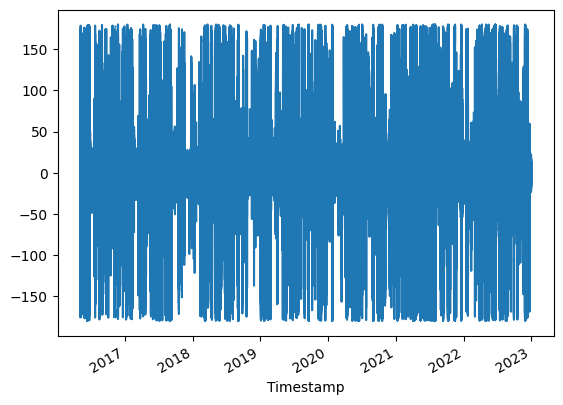

In [14]:
scada["Yaw error"].plot()

In [15]:
scada_clean = scada[(scada["Turbine"]!=target_turbine) 
                    | ((scada["Turbine"]==target_turbine) 
                        & (scada["Blade angle (pitch position) A (°)"]<10) 
                        & (scada["Blade angle (pitch position) A (°)"]>-1.5)
                        & (scada["Yaw error"]>-20)
                        & (scada["Yaw error"]<20)
                        )]

# scada_clean = scada.copy()


In [16]:
scada_clean

,Wind speed (m/s),wind_direction_cos,wind_direction_sin,Power (kW),Blade angle (pitch position) A (°),Turbine,Yaw error
Timestamp,,,,,,,
2016-01-03 00:00:00,NaN,NaN,NaN,NaN,NaN,Kelmarsh_1,NaN
2016-01-03 00:10:00,NaN,NaN,NaN,NaN,NaN,Kelmarsh_1,NaN
2016-01-03 00:20:00,NaN,NaN,NaN,NaN,NaN,Kelmarsh_1,NaN
2016-01-03 00:30:00,NaN,NaN,NaN,NaN,NaN,Kelmarsh_1,NaN
2016-01-03 00:40:00,NaN,NaN,NaN,NaN,NaN,Kelmarsh_1,NaN
...,...,...,...,...,...,...,...
2022-12-31 23:10:00,8.712688,-0.864330,-0.502924,1447.101428,0.1090,Kelmarsh_6,-4.735754
2022-12-31 23:20:00,9.149686,-0.879107,-0.476624,1572.766687,0.3910,Kelmarsh_6,-3.007247
2022-12-31 23:30:00,9.571797,-0.833503,-0.552514,1653.457245,1.1805,Kelmarsh_6,-8.081761


In [17]:
scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")

C:\Users\Charlie\AppData\Local\Temp\ipykernel_3352\4243526468.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")


In [18]:
scada_target = scada_clean[scada_clean["Turbine"]==target_turbine]

In [19]:
scada_others = scada_clean[scada_clean["Turbine"]!=target_turbine]

In [20]:
scada_others

,Turbine,Wind speed (m/s),wind_direction_cos,wind_direction_sin,Power (kW),Blade angle (pitch position) A (°),Yaw error
Timestamp,,,,,,,
2016-05-03 09:40:00,Kelmarsh_1,4.728757,0.118717,-0.992928,353.803345,0.000000,-8.452057
2016-05-03 09:40:00,Kelmarsh_2,7.122510,0.159681,-0.987169,630.782349,0.000000,-5.651367
2016-05-03 09:40:00,Kelmarsh_3,6.161213,0.077940,-0.996958,342.638336,0.000000,18.700836
2016-05-03 09:40:00,Kelmarsh_4,7.578357,0.060143,-0.998190,-0.458810,92.489998,3.796997
2016-05-03 09:40:00,Kelmarsh_5,4.782780,0.164590,-0.986362,295.982544,0.163333,-14.130432
...,...,...,...,...,...,...,...
2022-12-31 23:50:00,Kelmarsh_1,10.395954,-0.900412,-0.435039,1914.433063,2.629500,3.309480
2022-12-31 23:50:00,Kelmarsh_2,10.462493,-0.876594,-0.481231,1849.897888,2.008000,4.400185
2022-12-31 23:50:00,Kelmarsh_3,8.545551,-0.852017,-0.523513,1457.414063,0.620000,1.474814


In [21]:
X = scada_others.pivot(columns='Turbine')
y = scada_target

In [22]:
X.columns = [re.sub(r'[^a-zA-Z_0-9]','', '_'.join(map(str, col)).strip()) for col in X.columns]

In [23]:
X["yaw_error"] = scada_target["Yaw error"] # adding yaw error as a feature, so it can be used in determining what yaw error provides optimal power 

In [24]:
X

,Windspeedms_Kelmarsh_1,Windspeedms_Kelmarsh_2,Windspeedms_Kelmarsh_3,Windspeedms_Kelmarsh_4,Windspeedms_Kelmarsh_5,wind_direction_cos_Kelmarsh_1,wind_direction_cos_Kelmarsh_2,wind_direction_cos_Kelmarsh_3,wind_direction_cos_Kelmarsh_4,wind_direction_cos_Kelmarsh_5,...,BladeanglepitchpositionA_Kelmarsh_2,BladeanglepitchpositionA_Kelmarsh_3,BladeanglepitchpositionA_Kelmarsh_4,BladeanglepitchpositionA_Kelmarsh_5,Yawerror_Kelmarsh_1,Yawerror_Kelmarsh_2,Yawerror_Kelmarsh_3,Yawerror_Kelmarsh_4,Yawerror_Kelmarsh_5,yaw_error
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-05-03 09:40:00,4.728757,7.122510,6.161213,7.578357,4.782780,0.118717,0.159681,0.077940,0.060143,0.164590,...,0.0000,0.000000,92.489998,0.163333,-8.452057,-5.651367,18.700836,3.796997,-14.130432,18.365036
2016-05-03 09:50:00,6.427782,6.852325,5.983676,6.000396,6.196183,0.102479,-0.125456,-0.060676,0.248683,-0.060319,...,0.0000,0.000000,92.489998,0.000000,-7.515961,4.204407,-5.127136,-7.154572,-1.198883,-10.750610
2016-05-03 10:00:00,5.876329,5.057806,4.783360,5.793915,4.901711,0.012205,0.010078,0.078406,0.032012,-0.129257,...,0.0000,0.196997,92.489998,0.000000,-2.333313,-18.991425,-16.006805,5.410553,-16.595886,1.930908
2016-05-03 10:10:00,5.676786,5.723492,5.923840,5.609871,5.337160,0.139266,0.028372,0.120645,0.164504,-0.062794,...,0.0000,0.049000,92.489998,0.049000,-9.639404,3.895447,1.334473,-2.223419,-7.616089,-4.354431
2016-05-03 10:20:00,4.777902,4.905113,5.428344,3.955595,5.130708,0.257510,0.318388,0.261242,0.420119,0.111534,...,0.0000,0.246996,92.489998,0.049000,-16.556366,-11.735474,-2.948792,-17.597107,4.091248,-13.795105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:10:00,9.518300,9.631914,7.153512,8.585219,8.999645,-0.904634,-0.891264,-0.801798,-0.910730,-0.912751,...,0.5155,0.000000,0.200000,0.339000,8.482293,6.198618,-3.654858,4.802281,4.424406,-4.735754
2022-12-31 23:20:00,9.730098,9.295921,7.491813,8.558841,8.894581,-0.900639,-0.901414,-0.873131,-0.910343,-0.902979,...,0.4495,0.009000,0.427000,0.632000,3.339510,7.510591,3.867630,4.748701,3.088496,-3.007247
2022-12-31 23:30:00,9.848731,10.187608,8.186162,9.841343,10.057392,-0.841362,-0.839584,-0.788393,-0.892039,-0.882638,...,2.6350,0.441000,1.521500,2.522000,-3.618538,0.262215,-4.921393,2.326507,0.498255,-8.081761


# AutoML Wind Speed

In [25]:
target_feature = "Wind speed (m/s)"

In [26]:
model_path = f"AutogluonModels/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}_{target_turbine}_{autoML_duration_mins:02d}mins"

if os.path.exists(model_path):
    # Load your existing predictor from its saved directory
    predictor = TabularPredictor.load(model_path)

else:
    # Training with AutoGluon
    predictor = TabularPredictor(
        label=target_feature, 
        eval_metric='mae',
        path=model_path,
    )
    predictor.fit(
        train_data=pd.concat([X,y[target_feature]],axis=1), 
        time_limit=60*autoML_duration_mins, 
        presets='best_quality', 
        num_gpus='auto', 
        num_cpus='auto',
    )

In [ ]:
prediction_path = f"predictions/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}_{target_turbine}_{autoML_duration_mins:02d}mins.pkl"

if os.path.exists(prediction_path):
    # Load your existing predictor from its saved directory
    # Open the file for reading in binary mode
    with open(prediction_path, "rb") as file:
        # Load (deserialize) the object from the file
        target_prediction = pickle.load(file)

else:
    target_prediction = predictor.predict(X)

    # Open a file for writing in binary mode
    with open(prediction_path, "wb") as file:
        # Serialize and save the object to the file
        pickle.dump(target_prediction, file)

In [28]:
target_prediction.name = "target_prediction"

In [29]:
target_result = pd.concat([X,y,target_prediction],axis=1)

np.mean(abs(target_result["target_prediction"]-target_result[target_feature]))

0.16329685681769998

In [30]:
# Assuming y_true and y_pred are NumPy arrays
ss_res = np.sum((target_result[target_feature] - target_result["target_prediction"]) ** 2)
ss_tot = np.sum((target_result[target_feature] - np.mean(target_result["target_prediction"])) ** 2)
r2_manual = 1 - (ss_res / ss_tot)
print("R2:", r2_manual)

R2: 0.998726206868476


In [ ]:
X_tmp = X.copy()
X_tmp["yaw_error"] = 0

prediction_path = f"predictions/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}_yaw0_{target_turbine}_{autoML_duration_mins:02d}mins.pkl"

if os.path.exists(prediction_path):
    # Load your existing predictor from its saved directory
    # Open the file for reading in binary mode
    with open(prediction_path, "rb") as file:
        # Load (deserialize) the object from the file
        target_prediction_yaw0 = pickle.load(file)

else:
    target_prediction_yaw0 = predictor.predict(X_tmp)

    # Open a file for writing in binary mode
    with open(prediction_path, "wb") as file:
        # Serialize and save the object to the file
        pickle.dump(target_prediction_yaw0, file)

In [32]:
target_prediction_yaw0.name = "target_prediction_yaw0"

In [33]:
target_result = pd.concat([X,y,target_prediction_yaw0],axis=1)

np.mean(abs(target_result["target_prediction_yaw0"]-target_result[target_feature]))

0.20735434957081195

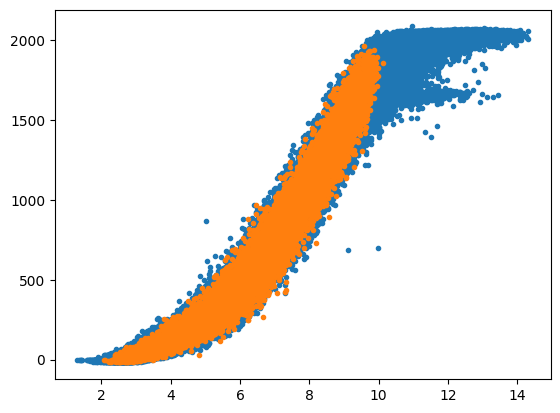

In [34]:
plt.figure()
plt.plot(target_result["Wind speed (m/s)"],target_result["Power (kW)"],marker='.',linestyle='')
plt.plot(target_result["target_prediction_yaw0"],target_result["Power (kW)"],marker='.',linestyle='')

plt.savefig(f"images/{target_turbine}_wind_speed_power_curve_{autoML_duration_mins:02d}mins.png")

plt.show()

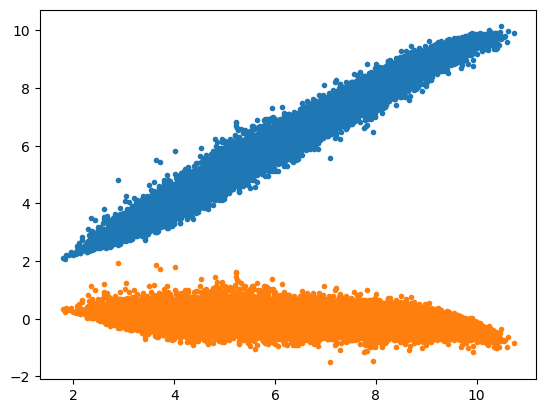

In [35]:
plt.figure()
plt.plot(target_result["Wind speed (m/s)"],target_result["target_prediction_yaw0"],marker='.',linestyle='')
plt.plot(target_result["Wind speed (m/s)"],target_result["target_prediction_yaw0"]-target_result["Wind speed (m/s)"],marker='.',linestyle='')

plt.savefig(f"images/{target_turbine}_wind_speed_comparison_{autoML_duration_mins:02d}mins.png")

plt.show()

In [36]:
ws_bins=[5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
vane_bins=np.linspace(-25,25,51)

target_result['yaw_bin'] = pd.cut(target_result['Yaw error'], vane_bins)

# target_result_filtered['ws_bin'] = pd.cut(target_result_filtered['Wind speed (m/s)'], ws_bins)
target_result['ws_bin'] = pd.cut(target_result['target_prediction_yaw0'], ws_bins)

In [37]:
target_result_sye = target_result.groupby(by=["ws_bin","yaw_bin"]).agg(
    Median=("Power (kW)", 'median'),
    Count=("Power (kW)", 'count'),
    Mean=("Power (kW)", 'mean'))

target_result_sye = target_result_sye.reset_index()


C:\Users\Charlie\AppData\Local\Temp\ipykernel_3352\2066444576.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_result_sye = target_result.groupby(by=["ws_bin","yaw_bin"]).agg(


In [38]:
target_result_sye["ws_bin_left"] = pd.IntervalIndex(target_result_sye['ws_bin']).left
target_result_sye["yaw_bin_left"] = pd.IntervalIndex(target_result_sye['yaw_bin']).left

sye_data = target_result_sye.dropna()

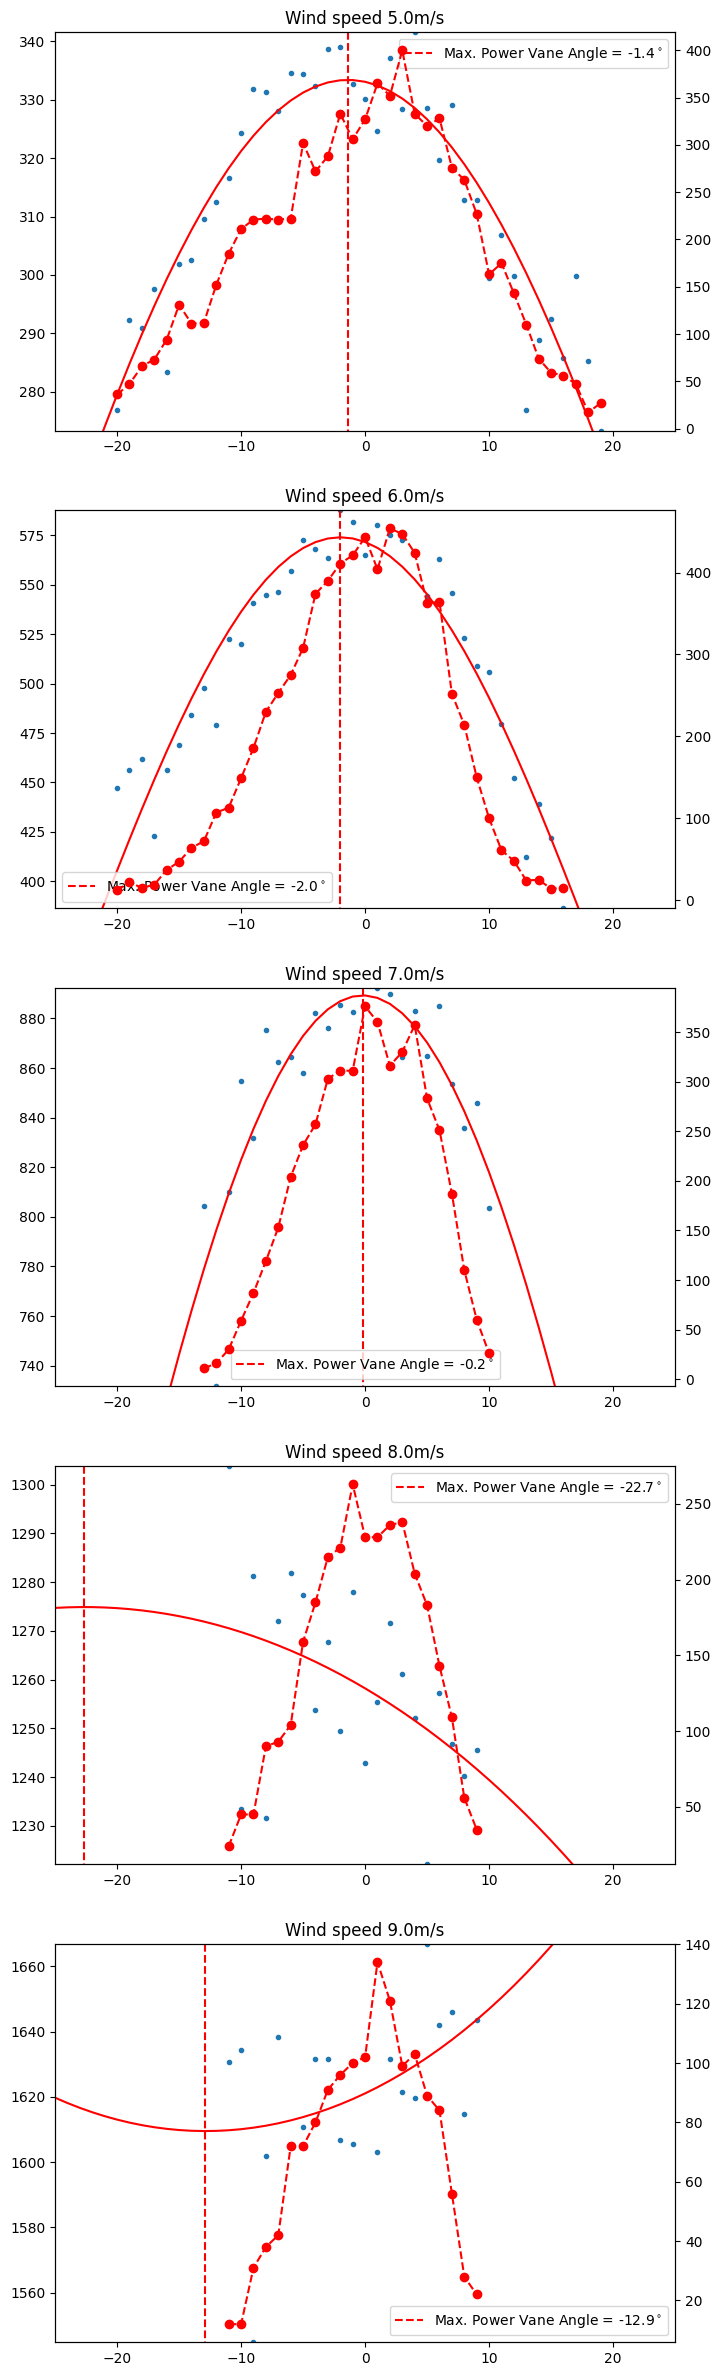

In [39]:
total_sub_figures =  len(set(sye_data["ws_bin_left"]))

fig = plt.figure(figsize=(8, 6*total_sub_figures))
i = 0

for ws_bin in set(sye_data["ws_bin_left"]):
    sye_ws_bin = sye_data[sye_data["ws_bin_left"]==ws_bin]
    
    sye_ws_bin = sye_ws_bin[sye_ws_bin["Count"]>10] # filter out bins with low counts
       
    i = i+1
    ax = plt.subplot(total_sub_figures, 1, i)  # (nrows, ncols, index)

    ax.plot(sye_ws_bin["yaw_bin_left"],sye_ws_bin["Median"],marker=".",linestyle="")

    curve_fit_params = curve_fit(cos_curve, 
            sye_ws_bin["yaw_bin_left"], 
            sye_ws_bin["Median"], 
            [sye_ws_bin["Median"].max(), 0.0, 2.0],
            maxfev=1000)[0]

    ax.plot(vane_bins,cos_curve(vane_bins,*curve_fit_params),c="red")
    
    ax.plot(
        2*[curve_fit_params[1]],
        [
                sye_ws_bin["Median"].max(),
                sye_ws_bin["Median"].min(),
        ],
        color="red",
        linestyle="--",
        label=rf"Max. Power Vane Angle = {round(curve_fit_params[1],1)}$^\circ$",  # noqa: W605
        )
    
    ax2 = ax.twinx()
    ax2.plot(sye_ws_bin["yaw_bin_left"], sye_ws_bin["Count"], marker="o", linestyle="--", color="red", label="Count")

    plt.title(f"Wind speed {ws_bin}m/s")
    
    ax.legend()
    ax.set_xlim([-25,25])
    ax.set_ylim([sye_ws_bin["Median"].min(),sye_ws_bin["Median"].max()])

plt.savefig(f"images/{target_turbine}_wind_speed_yaw_analysis_{autoML_duration_mins:02d}mins.png")

plt.show()

# AutoML Power

In [40]:
target_feature = "Power (kW)"

In [41]:
model_path = f"AutogluonModels/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}_{target_turbine}_{autoML_duration_mins:02d}mins"

if os.path.exists(model_path):
    # Load your existing predictor from its saved directory
    predictor = TabularPredictor.load(model_path)

else:    
    # Training with AutoGluon
    predictor = TabularPredictor(
        label=target_feature, 
        eval_metric='mae',
        path=model_path,
    )
    predictor.fit(
        train_data=pd.concat([X,y[target_feature]],axis=1), 
        time_limit=60*autoML_duration_mins, 
        presets='best_quality', 
        num_gpus='auto', 
        num_cpus='auto',
    )

In [42]:
prediction_path = f"predictions/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}_{target_turbine}_{autoML_duration_mins:02d}mins.pkl"

if os.path.exists(prediction_path):
    # Load your existing predictor from its saved directory
    # Open the file for reading in binary mode
    with open(prediction_path, "rb") as file:
        # Load (deserialize) the object from the file
        target_prediction = pickle.load(file)

else:
    target_prediction = predictor.predict(X)

    # Open a file for writing in binary mode
    with open(prediction_path, "wb") as file:
        # Serialize and save the object to the file
        pickle.dump(target_prediction, file)



In [43]:
target_prediction.name = "target_prediction"

In [44]:
target_result = pd.concat([X,y,target_prediction],axis=1)

np.mean(abs(target_result["target_prediction"]-target_result[target_feature]))

24.540925350353103

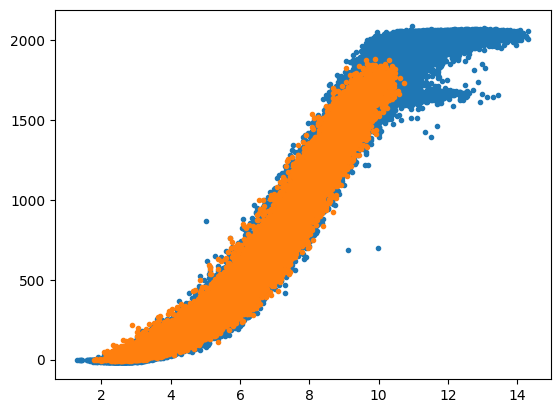

In [45]:
plt.figure()
plt.plot(target_result["Wind speed (m/s)"],target_result["Power (kW)"],marker='.',linestyle='')
plt.plot(target_result["Wind speed (m/s)"],target_result["target_prediction"],marker='.',linestyle='')

plt.savefig(f"images/{target_turbine}_power_power_curve_{autoML_duration_mins:02d}mins.png")

plt.show()

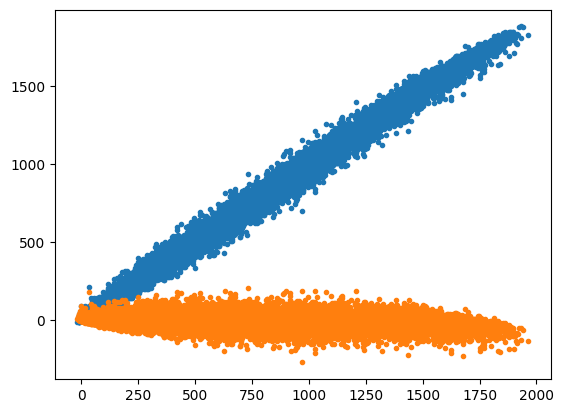

In [46]:
plt.figure()
plt.plot(target_result[target_feature],target_result["target_prediction"],marker='.',linestyle='')
plt.plot(target_result[target_feature],target_result["target_prediction"]-target_result[target_feature],marker='.',linestyle='')
# plt.ylim([-5,20])

plt.savefig(f"images/{target_turbine}_power_comparison_{autoML_duration_mins:02d}mins.png")

plt.show()

# Using power predictions for SYE estimates

In [ ]:
X_tmp = X.copy()
X_tmp["yaw_error"] = 0

prediction_path = f"predictions/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}_yaw0_{target_turbine}_{autoML_duration_mins:02d}mins.pkl"

if os.path.exists(prediction_path):
    # Load your existing predictor from its saved directory
    # Open the file for reading in binary mode
    with open(prediction_path, "rb") as file:
        # Load (deserialize) the object from the file
        target_prediction_yaw0 = pickle.load(file)

else:
    target_prediction_yaw0 = predictor.predict(X_tmp)

    # Open a file for writing in binary mode
    with open(prediction_path, "wb") as file:
        # Serialize and save the object to the file
        pickle.dump(target_prediction_yaw0, file)

In [48]:
yaw_bins = range(-10,11,1)
yaw_bin = pd.cut(X["yaw_error"],yaw_bins)
yaw_level = list(pd.IntervalIndex(yaw_bin).mid)

In [49]:
power_bins = range(0,2500,250)
power_bin = pd.cut(target_prediction,power_bins)
power_level = list(pd.IntervalIndex(power_bin).mid)

In [50]:
target_result = pd.DataFrame(target_prediction.copy())

In [51]:
target_result["yaw_level"] = yaw_level
target_result["power_level"] = power_level
target_result["target_prediction"] = target_prediction
target_result["target_prediction_yaw0"] = target_prediction_yaw0
target_result["Power (kW)"] = y["Power (kW)"]

ValueError: Length of values (277676) does not match length of index (37343)

In [ ]:
# target_result = target_result.groupby(by=["power_level","yaw_level"])[["power_delta_actual","power_delta_model","power_delta_model"]].agg([["mean","mean","count"]])

target_result = target_result.groupby(by=["power_level","yaw_level"]).agg(
    target_prediction = ('target_prediction', 'median'),
    target_prediction_yaw0 = ('target_prediction_yaw0', 'median'),
    power_actual = ('Power (kW)', 'median'),
    power_delta_count = ('target_prediction_yaw0', 'count')
)
target_result = pd.DataFrame(target_result)

In [ ]:
target_result = target_result[target_result['power_delta_count'] >= 10]

In [ ]:
target_result

target_prediction  target_prediction_yaw0  \
power_level yaw_level                                              
125.0       -9.5              115.254173              119.194626   
            -8.5              118.568222              122.024582   
            -7.5              119.107010              121.421143   
            -6.5              117.439667              119.539452   
            -5.5              117.032555              118.543365   
...                                  ...                     ...   
2125.0       5.5             2025.715576             2025.035645   
             6.5             2026.880981             2027.017578   
             7.5             2026.419434             2027.274536   
             8.5             2025.660156             2027.854492   
             9.5             2022.484985             2031.411865   

                       power_actual  power_delta_count  
power_level yaw_level                                   
125.0       -9.5         106.878565               2615  
            -8.5         113.440678               2776  
            -7.5         112.818691               2962  
            -6.5         109.625160               2991  
            -5.5         111.415718               3089  
...                             ...                ...  
2125.0       5.5        2035.048401                248  
             6.5        2033.750623                220  
             7.5        2037.738525                139  
             8.5        2039.189370                 93  
             9.5        2041.722400                 44  

[180 rows x 4 columns]

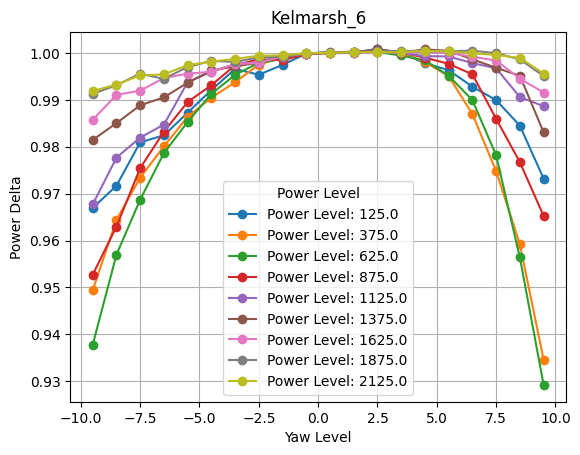

In [ ]:
plt.figure()

# Group by the first level of the MultiIndex, e.g., 'power_level'
for power_level, group in target_result.groupby(level='power_level'):
    # Extract the 'yaw_level' values from the second index level
    yaw_levels = group.index.get_level_values('yaw_level')
    plt.plot(yaw_levels, group['target_prediction']/group['target_prediction_yaw0'], marker='o', linestyle='-', label=f'Power Level: {power_level}')

plt.xlabel('Yaw Level')
plt.ylabel('Power Delta')
plt.legend(title='Power Level')
plt.title(target_turbine)
plt.grid(True)

plt.savefig(f"images/{target_turbine}_power_model_{autoML_duration_mins:02d}mins.png")

plt.show()

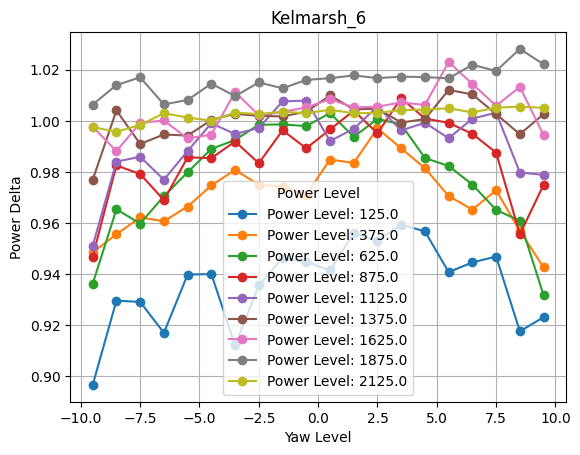

In [ ]:
plt.figure()

# Group by the first level of the MultiIndex, e.g., 'power_level'
for power_level, group in target_result.groupby(level='power_level'):
    # Extract the 'yaw_level' values from the second index level
    yaw_levels = group.index.get_level_values('yaw_level')
    plt.plot(yaw_levels, group['power_actual']/group['target_prediction_yaw0'], marker='o', linestyle='-', label=f'Power Level: {power_level}')

plt.xlabel('Yaw Level')
plt.ylabel('Power Delta')
plt.legend(title='Power Level')
plt.title(target_turbine)
plt.grid(True)

plt.savefig(f"images/{target_turbine}_power_actual_{autoML_duration_mins:02d}mins.png")

plt.show()

# Change in performance over time?

Compare expect power to actual

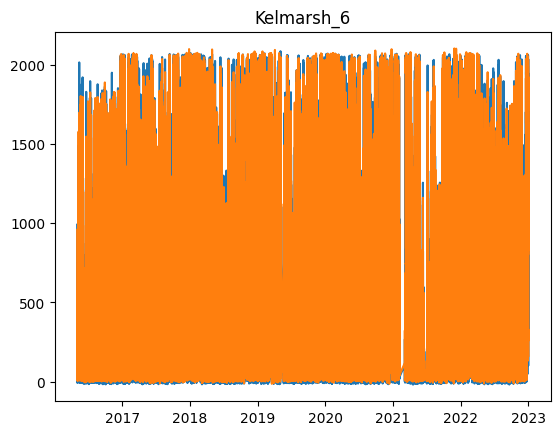

In [ ]:
plt.figure()
plt.plot(y[target_feature])
plt.plot(target_prediction)
# plt.ylim([-5,20])
plt.title(target_turbine)

plt.savefig(f"images/{target_turbine}_power_timeseries_{autoML_duration_mins:02d}mins.png")

plt.show()

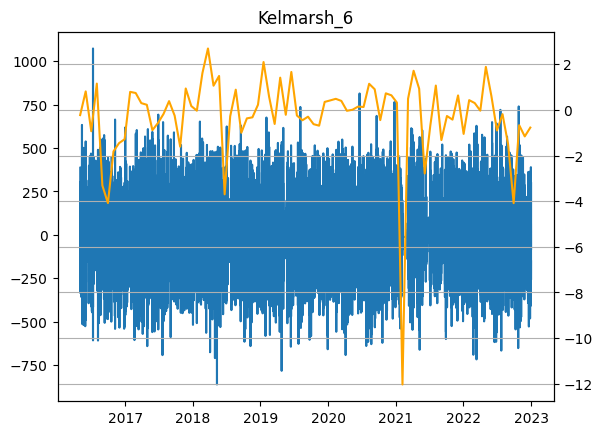

In [ ]:
fig, ax = plt.subplots()

plt.title(target_turbine)

ax.plot(y[target_feature]-target_prediction)

# plt.ylim([-5,20])

ax2 = ax.twinx()

ax2.plot(100*((y[target_feature]-target_prediction).resample("30D").sum())/(y[target_feature].resample("30D").sum()),color="orange", label="30day % delta")

ax2.grid()

plt.savefig(f"images/{target_turbine}_power_delta_timeseries_{autoML_duration_mins:02d}mins.png")

plt.show()

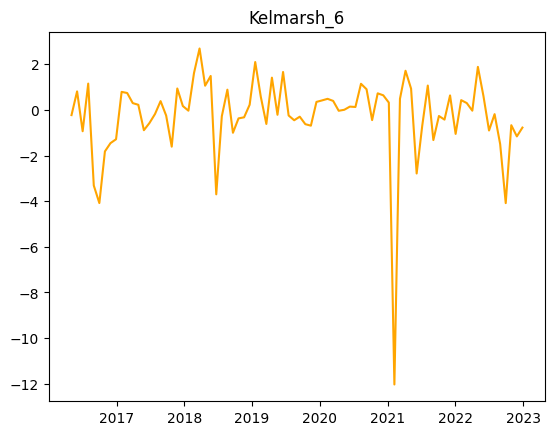

In [ ]:
fig, ax = plt.subplots()

plt.title(target_turbine)

plt.plot(100*((y[target_feature]-target_prediction).resample("30D").sum())/(y[target_feature].resample("30D").sum()),color="orange", label="30day % delta")

plt.savefig(f"images/{target_turbine}_power_pc_delta_timeseries_{autoML_duration_mins:02d}mins.png")

plt.show()